In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import sys
from sklearn.preprocessing import StandardScaler

sys.path.append('../src')


# Load the data
df = pd.read_csv('../data/xrp_usdt_data.csv', index_col='timestamp', parse_dates=True)

# Calculate log returns
log_returns = np.log(df['close'] / df['close'].shift(1)).dropna()

# NEW: Get the corresponding volume for each log return
volume = df['volume'].loc[log_returns.index]

# NEW: Create a volume-weighted series for the model to analyze
# We scale the volume to prevent numerical issues
volume_scaled = (volume - volume.mean()) / volume.std()
analysis_series = log_returns * (1 + volume_scaled) # Use this as the input

# --- Now, feed 'analysis_series' into the model ---
# Make sure to also standardize this new series before the model
scaler = StandardScaler()
scaled_analysis_series = scaler.fit_transform(analysis_series.values.reshape(-1, 1)).flatten()

In [2]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

with pm.Model() as two_regime_model:
    # Priors for the two regimes (low-vol vs high-vol)
    mu = pm.Normal('mu', mu=0.0, sigma=0.001, shape=2) # Tighter prior for 1h data
    sigma = pm.HalfNormal('sigma', sigma=0.005, shape=2) # Tighter prior for 1h data

    # Continuous Change Point Formulation
    change_point = pm.Uniform("change_point", lower=0, upper=len(log_returns))
    steepness = pm.HalfNormal("steepness", sigma=1)

    # Use a sigmoid function for a smooth transition
    time_idx = np.arange(len(log_returns))
    weight = pm.Deterministic(
        "weight", 
        pm.math.sigmoid(steepness * (time_idx - change_point))
    )

    # Weighted Likelihood
    mu_blend = mu[0] * (1 - weight) + mu[1] * weight
    sigma_blend = sigma[0] * (1 - weight) + sigma[1] * weight

    likelihood = pm.StudentT(
    'likelihood',
    nu=4,
    mu=mu_blend,
    sigma=sigma_blend,
    observed=scaled_analysis_series # Use the scaled data here
    )
    
    # Sample from the model
    trace = pm.sample(
    draws=4000,
    tune=3000,  # Increased from 2000
    chains=4,
    cores=1,
    target_accept=0.95
    )

Initializing NUTS using jitter+adapt_diag...
/home/giuseppe/xrp-regime-detection/.venv/lib/python3.12/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Sequential sampling (4 chains in 1 job)
NUTS: [mu, sigma, change_point, steepness]


Output()

/home/giuseppe/xrp-regime-detection/.venv/lib/python3.12/site-packages/pymc/step_methods/hmc/quadpotential.py:316: 
RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)

Sampling 4 chains for 3_000 tune and 4_000 draw iterations (12_000 + 16_000 draws total) took 227 seconds.


In [7]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import sys
from sklearn.preprocessing import StandardScaler
from data_fetcher import fetch_recent_data

sys.path.append('../src')

# 1. Fetch the data
df_5min = fetch_recent_data(hours_back=120, timeframe='5m')

# 2. Prepare the data (standardize the log returns)
log_returns = np.log(df_5min['close'] / df_5min['close'].shift(1)).dropna()
scaler = StandardScaler()
scaled_log_returns = scaler.fit_transform(log_returns.values.reshape(-1, 1)).flatten()

# 3. Define and run the Bayesian micro-regime model
with pm.Model() as micro_regime_model:
    # Priors for the two regimes (ranging vs. active)
    # Tighter priors suitable for 5-minute data
    mu = pm.Normal('mu', mu=0.0, sigma=0.0005, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=0.001, shape=2)

    # Continuous Change Point Formulation
    change_point = pm.Uniform("change_point", lower=0, upper=len(scaled_log_returns))
    steepness = pm.HalfNormal("steepness", sigma=1)

    # Sigmoid transition
    time_idx = np.arange(len(scaled_log_returns))
    weight = pm.Deterministic(
        "weight", 
        pm.math.sigmoid(steepness * (time_idx - change_point))
    )

    # Weighted Likelihood
    mu_blend = mu[0] * (1 - weight) + mu[1] * weight
    sigma_blend = sigma[0] * (1 - weight) + sigma[1] * weight

    likelihood = pm.StudentT(
        'likelihood',
        nu=4,
        mu=mu_blend,
        sigma=sigma_blend,
        observed=scaled_log_returns
    )
    
    # Sample from the model
    trace = pm.sample(
    draws=2000,
    tune=2500,  # Increased from 1500
    chains=4,
    cores=1,
    target_accept=0.95
    )

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu, sigma, change_point, steepness]


Output()

Sampling 4 chains for 2_500 tune and 2_000 draw iterations (10_000 + 8_000 draws total) took 73 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


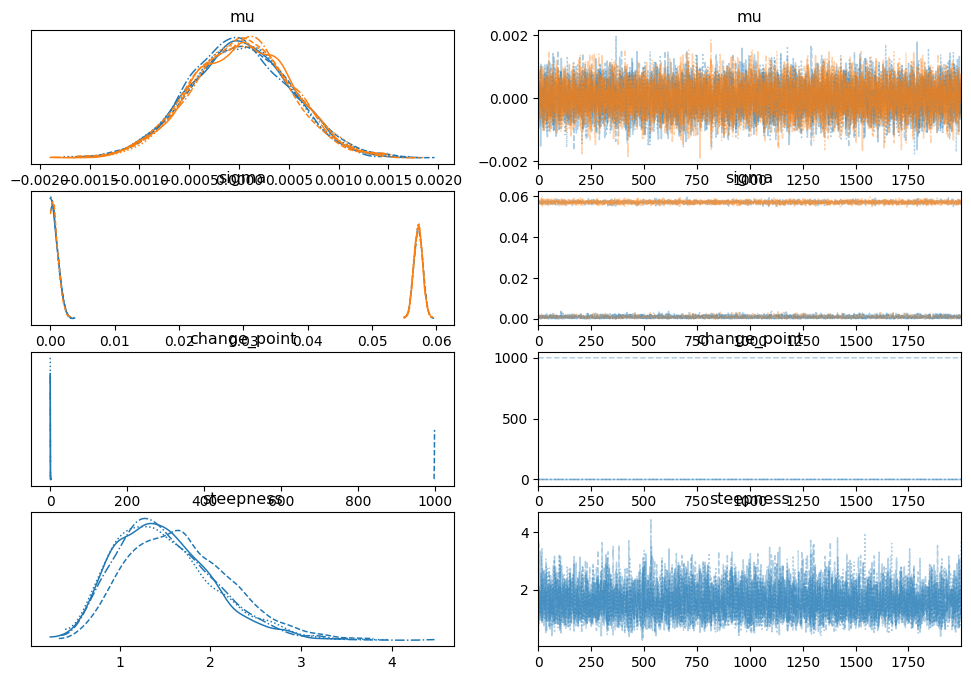

In [8]:
import arviz as az
import matplotlib.pyplot as plt

az.plot_trace(trace, var_names=['mu', 'sigma', 'change_point', 'steepness'])
plt.show()

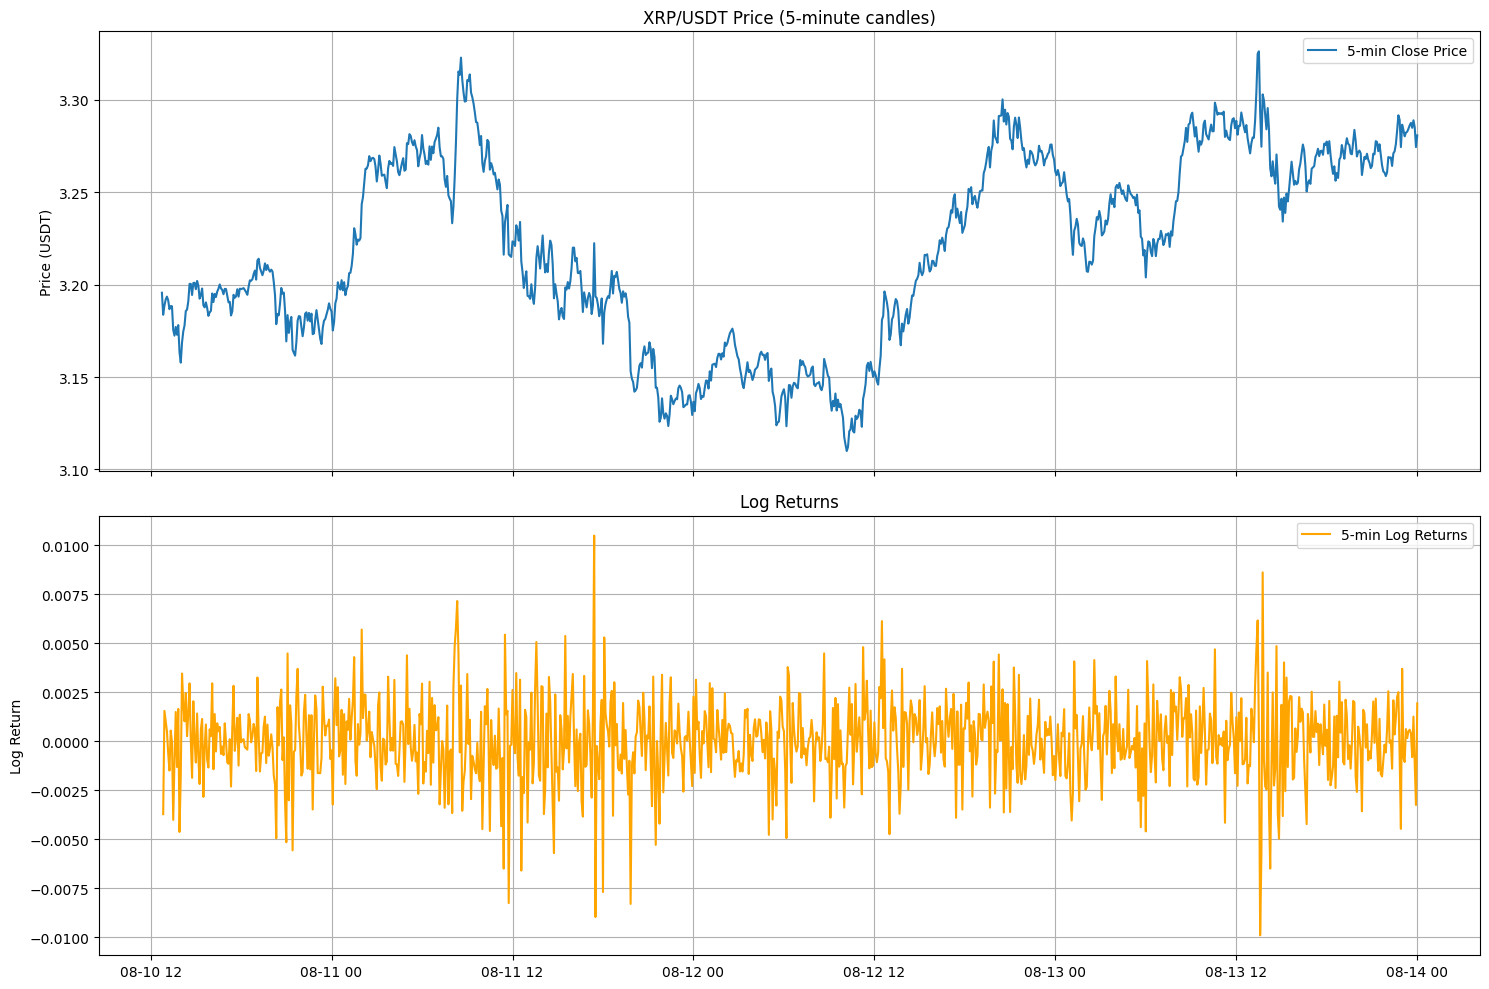

In [9]:
# Assuming 'df_5min' is your DataFrame with the 5-minute data

# Calculate log returns for visualization
log_returns_5min = np.log(df_5min['close'] / df_5min['close'].shift(1)).dropna()

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

ax1.plot(df_5min.index, df_5min['close'], label='5-min Close Price')
ax1.set_title('XRP/USDT Price (5-minute candles)')
ax1.set_ylabel('Price (USDT)')
ax1.grid(True)
ax1.legend()

ax2.plot(log_returns_5min.index, log_returns_5min, label='5-min Log Returns', color='orange')
ax2.set_title('Log Returns')
ax2.set_ylabel('Log Return')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

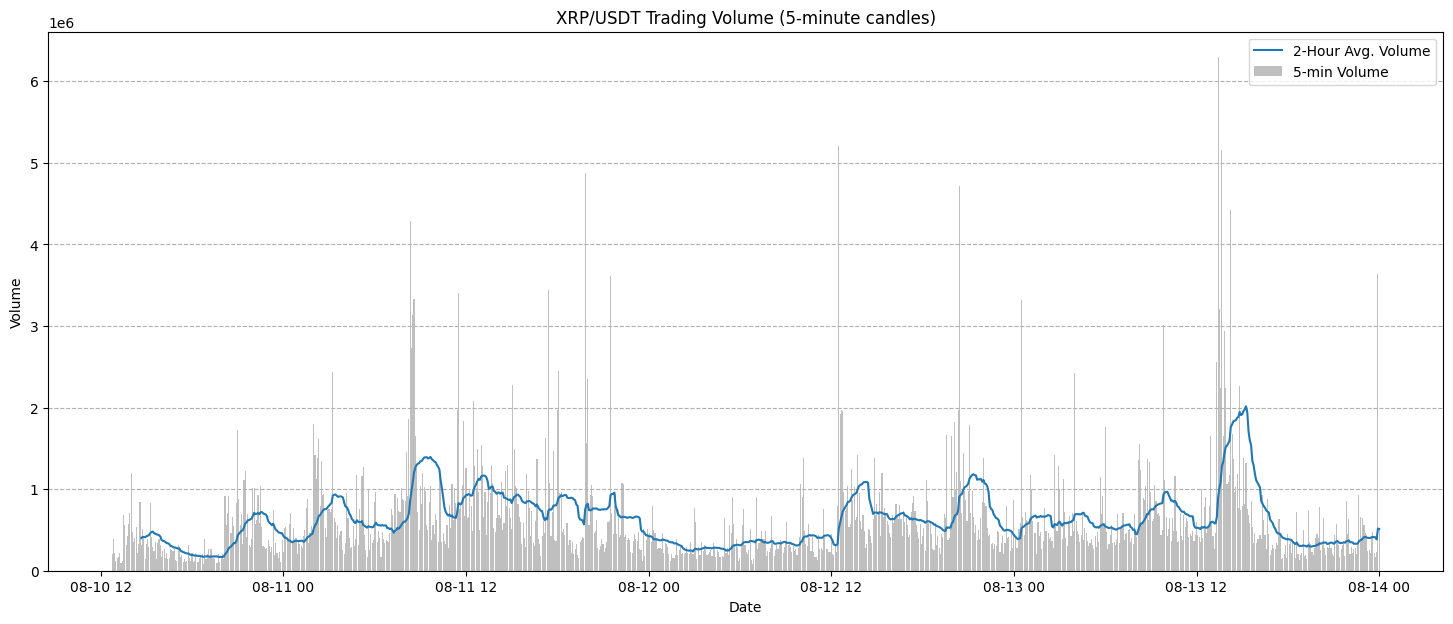

In [10]:
import matplotlib.pyplot as plt

# --- Plotting Volume and its Rolling Average ---

# Calculate a rolling average of the volume to see the trend
# 24 periods on a 5-min chart = 2 hours (24 * 5 = 120 minutes)
rolling_avg_volume = df_5min['volume'].rolling(window=24).mean()

# Create the plot
fig, ax = plt.subplots(figsize=(18, 7))

# Plot the raw volume as bars
ax.bar(df_5min.index, df_5min['volume'], label='5-min Volume', color='grey', alpha=0.5, width=0.003)

# Plot the rolling average as a line
ax.plot(rolling_avg_volume.index, rolling_avg_volume, label='2-Hour Avg. Volume', color='C0')

ax.set_title('XRP/USDT Trading Volume (5-minute candles)')
ax.set_xlabel('Date')
ax.set_ylabel('Volume')
ax.grid(axis='y', linestyle='--')
ax.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import sys
from sklearn.preprocessing import StandardScaler
from data_fetcher import fetch_recent_data

sys.path.append('../src')

# Use the 5-day, 5-minute dataframe
df_5min = fetch_recent_data(hours_back=120, timeframe='5m')

# Prepare the volume data for the model
log_volume = np.log(df_5min['volume']).dropna()

# Standardize the log_volume
scaler = StandardScaler()
scaled_log_volume = scaler.fit_transform(log_volume.values.reshape(-1, 1)).flatten()

with pm.Model() as volume_regime_model:
    # Priors for the mean and std dev of the LOG of volume in each regime
    mu = pm.Normal('mu', mu=0.0, sigma=1.0, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=1.0, shape=2)

    # Continuous Change Point logic (this now finds the transition in the volume cycle)
    change_point = pm.Uniform("change_point", lower=0, upper=len(scaled_log_volume))
    steepness = pm.HalfNormal("steepness", sigma=1)

    time_idx = np.arange(len(scaled_log_volume))
    weight = pm.Deterministic(
        "weight", 
        pm.math.sigmoid(steepness * (time_idx - change_point))
    )

    # Blended parameters
    mu_blend = mu[0] * (1 - weight) + mu[1] * weight
    sigma_blend = sigma[0] * (1 - weight) + sigma[1] * weight

    # Likelihood using the volume data
    likelihood = pm.Normal( # Using a Normal distribution is fine for the log-transformed data
        'likelihood',
        mu=mu_blend,
        sigma=sigma_blend,
        observed=scaled_log_volume
    )
    
    # Sample from the model
    trace = pm.sample(
    draws=2000,
    tune=3000,  # Increased from 2000
    chains=4,
    cores=1,
    target_accept=0.9
    )

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu, sigma, change_point, steepness]


Output()

/home/giuseppe/xrp-regime-detection/.venv/lib/python3.12/site-packages/pymc/step_methods/hmc/quadpotential.py:316: 
RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 33 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
# --- This cell runs the Bayesian model (you already have this) ---
# (It's assumed you have run the model and have the 'trace' object)

# --- Add this NEW cell to dynamically analyze and plot signals ---

import arviz as az
import sys
sys.path.append('../src')
from signal_generator import calculate_indicators
from visualization import plot_trading_signals

print("--- Dynamic Signal Analysis ---")

# 1. Extract the posteriors for sigma and the regime weights
sigma_posteriors = az.extract(trace, var_names=["sigma"]).values
weight_posteriors = az.extract(trace, var_names=["weight"]).values

# 2. Characterize the regimes by their average volatility
mean_sigma_regime_0 = sigma_posteriors[0, :].mean()
mean_sigma_regime_1 = sigma_posteriors[1, :].mean()

if mean_sigma_regime_0 < mean_sigma_regime_1:
    low_vol_regime_index = 0
    high_vol_regime_index = 1
    print(f"Regime 0 is Low-Volatility (avg sigma: {mean_sigma_regime_0:.4f})")
    print(f"Regime 1 is High-Volatility (avg sigma: {mean_sigma_regime_1:.4f})")
else:
    low_vol_regime_index = 1
    high_vol_regime_index = 0
    print(f"Regime 1 is Low-Volatility (avg sigma: {mean_sigma_regime_1:.4f})")
    print(f"Regime 0 is High-Volatility (avg sigma: {mean_sigma_regime_0:.4f})")
    
# 3. Determine the current market state
# Get the probability of being in Regime 1 at the most recent time step
prob_of_regime_1_now = weight_posteriors[-1, :].mean()

# Make the dynamic decision
if high_vol_regime_index == 1:
    # If Regime 1 is the high-vol regime
    if prob_of_regime_1_now > 0.5:
        current_regime_decision = 'high_volatility'
    else:
        current_regime_decision = 'low_volatility'
else:
    # If Regime 0 is the high-vol regime
    if prob_of_regime_1_now < 0.5:
        current_regime_decision = 'high_volatility'
    else:
        current_regime_decision = 'low_volatility'

print(f"\nProbability of being in Regime 1 now is: {prob_of_regime_1_now:.2f}")
print(f"DECISION: The current market is in a '{current_regime_decision}' state.")
print("Generating the appropriate tactical signals...")

# 4. Calculate indicators and plot the chosen signals
indicator_df = calculate_indicators(df)
plot_trading_signals(indicator_df, regime_type=current_regime_decision)

/home/giuseppe/xrp-regime-detection/notebooks/../src/visualization.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(bb_buy_signals.index[i], bb_buy_signals['close'][i], '^', markersize=10,
/home/giuseppe/xrp-regime-detection/notebooks/../src/visualization.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(bb_sell_signals.index[i], bb_sell_signals['close'][i], 'v', markersize=10,
/home/giuseppe/xrp-regime-detection/notebooks/../src/visualization.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (co

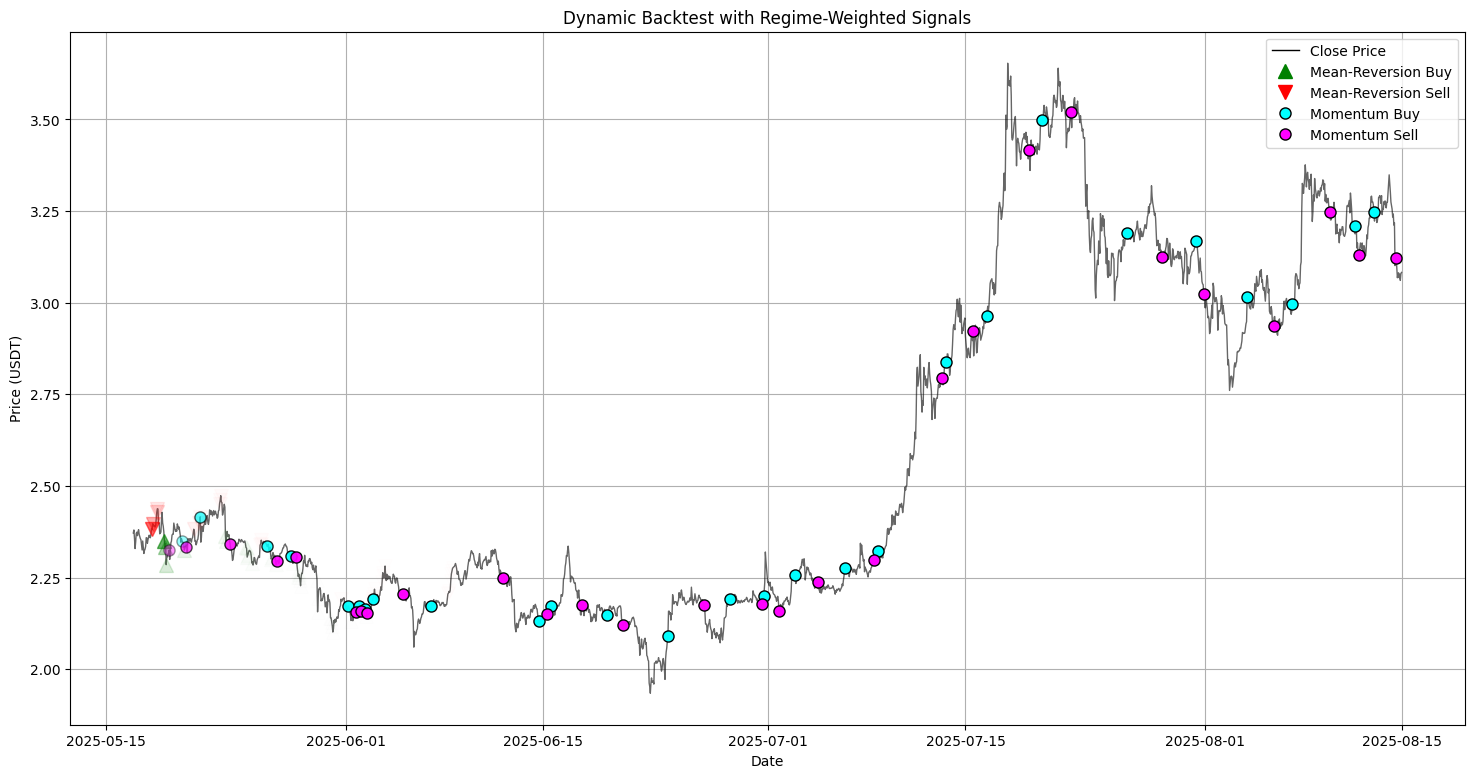

In [3]:
# Restart your kernel to import the new function!

import sys
sys.path.append('../src')
from visualization import plot_dynamic_backtest
from signal_generator import calculate_indicators

# Calculate the indicators (if you haven't already)
indicator_df = calculate_indicators(df)

# Call the new dynamic backtest plotting function
plot_dynamic_backtest(indicator_df, trace)

In [ ]:
# Restart your kernel first!

import sys
sys.path.append('../src')
from visualization import plot_price_and_returns, plot_three_regime_transition
import arviz as az
import matplotlib.pyplot as plt

# Plot the initial data
plot_price_and_returns(df, log_returns)

# Plot the new three-regime results
plot_three_regime_transition(df, trace, log_returns)

# You can now inspect the parameters for all three regimes
az.plot_trace(trace, var_names=['mu', 'sigma', 'change_points'])
plt.show()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.1614
Link Function:                     IdentityLink Log Likelihood:                                 -1352.0135
Number of Samples:                         1000 AIC:                                             2730.3497
                                                AICc:                                            2730.7279
                                                GCV:                                                0.8989
                                                Scale:                                              0.8793
                                                Pseudo R-Squared:                                   0.1314
Feature Function                  Lam

/tmp/ipykernel_757/1313403567.py:25: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


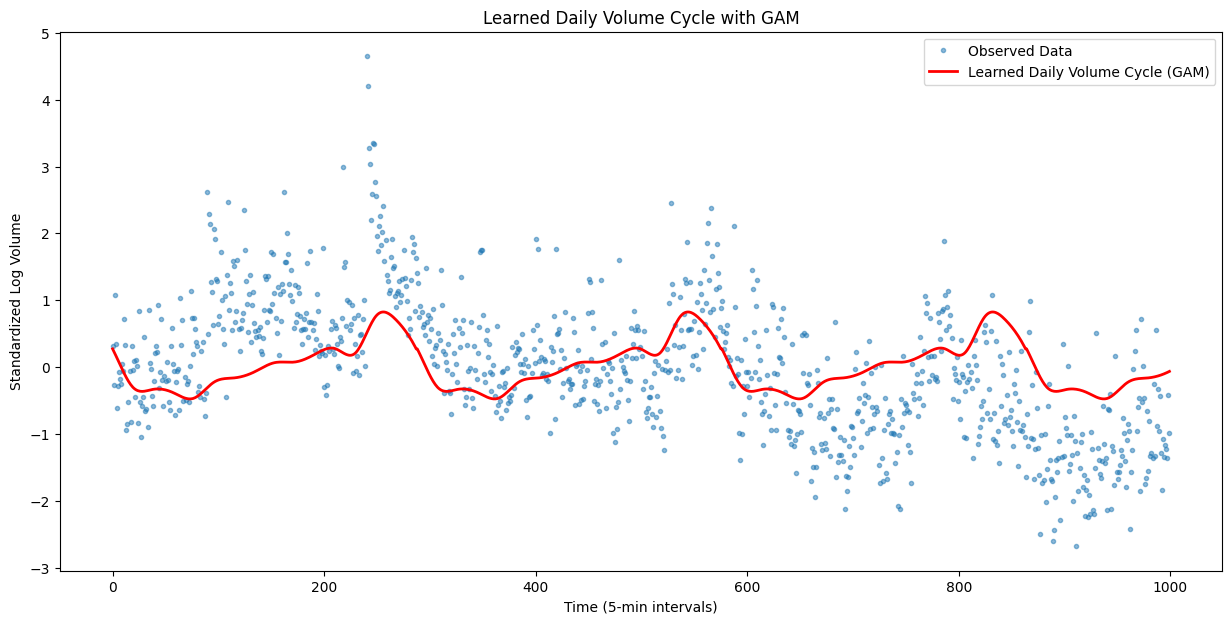

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from pygam import LinearGAM, s, f # Import GAM components
import sys
import matplotlib.pyplot as plt
sys.path.append('../src')

from data_fetcher import fetch_recent_data


# --- 1. Prepare the Data ---
df_5min = fetch_recent_data(hours_back=120, timeframe='5m')
log_volume = np.log(df_5min['volume']).dropna()
scaler = StandardScaler()
scaled_log_volume = scaler.fit_transform(log_volume.values.reshape(-1, 1))
time_idx = np.arange(len(scaled_log_volume))

# --- 2. Build and Fit the GAM ---
# We model the volume using a cyclical feature for the time of day
# 288 is the number of 5-min intervals in a day
time_of_day = time_idx % 288 

# 's(0)' creates a smooth spline for the cyclical time_of_day feature
gam = LinearGAM(s(0, n_splines=15, basis='cp')).fit(time_of_day, scaled_log_volume)
gam.summary()

# --- 3. Plot the Learned Cycle ---
plt.figure(figsize=(15, 7))
plt.plot(time_idx, scaled_log_volume, 'o', ms=3, alpha=0.5, label="Observed Data")
plt.plot(time_idx, gam.predict(time_of_day), color='r', lw=2, label="Learned Daily Volume Cycle (GAM)")

plt.title("Learned Daily Volume Cycle with GAM")
plt.xlabel("Time (5-min intervals)")
plt.ylabel("Standardized Log Volume")
plt.legend()
plt.show()

In [ ]:
import pymc as pm
import arviz as az

with pm.Model() as gp_model:
    # Priors for the GP kernel
    eta = pm.HalfNormal("eta", sigma=1.0)  # Amplitude of the covariance
    ls = pm.Gamma("ls", alpha=2.0, beta=1.0)    # Lengthscale of the covariance
    
    # Prior for the period of the cycle (centered around 1 day = 288 5-min candles)
    period = pm.Normal("period", mu=288, sigma=10)
    
    # Define the periodic covariance function
    cov = eta**2 * pm.gp.cov.Periodic(1, period=period, ls=ls)
    
    # Define the Gaussian Process
    gp = pm.gp.Marginal(cov_func=cov)
    
    # Define the noise and the likelihood
    sigma = pm.HalfNormal("sigma", sigma=1.0)
    y_ = gp.marginal_likelihood("y", X=time_idx, y=scaled_log_volume, sigma=sigma)
    
    # Sample from the posterior
    trace = pm.sample(2000, tune=2000, chains=4, cores=1, target_accept=0.9)

Initializing NUTS using jitter+adapt_diag...
/home/giuseppe/xrp-regime-detection/.venv/lib/python3.12/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(


In [ ]:
# Create a set of points to plot the prediction on
X_new = np.arange(len(scaled_log_volume) + 50).reshape(-1, 1) # Plotting into the future

# Get the conditional posterior prediction
mu, var = gp.predict(X_new, trace=trace)

# Plot the results
plt.figure(figsize=(15, 7))
plt.plot(time_idx, scaled_log_volume, 'o', ms=3, alpha=0.5, label="Observed Data")
plt.plot(X_new, mu.mean(axis=0), label="Mean GP Prediction (Volume Cycle)")
az.plot_hdi(X_new.flatten(), mu, hdi_prob=0.94, color="C1", fill_kwargs={"alpha": 0.3})

plt.title("Learned Daily Volume Cycle with Gaussian Process")
plt.xlabel("Time (5-min intervals)")
plt.ylabel("Standardized Log Volume")
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import sys
sys.path.append('../src')
from visualization import plot_gam_backtest

# Load the results from the backtest script
backtest_results = pd.read_csv('../data/backtest_results.csv', index_col='timestamp', parse_dates=True)

# Create the complete backtest visualization
plot_gam_backtest(backtest_results)

FileNotFoundError: [Errno 2] No such file or directory: 'data/backtest_results.csv'